In [1]:
# import all necessary libraries
import numpy as np
import pandas as pd
import geopandas as gpd

import sys, os
import sklearn
import datetime

import importlib
from tqdm import tqdm
import random

from joblib import Parallel, delayed
import multiprocessing

In [2]:
# Set random seed
random.seed(42)
np.random.seed(42)

In [4]:
import argparse

In [5]:
import torch
import torch.nn as nn

In [6]:
import torch.optim as optim

In [7]:
X = pd.read_pickle('Final\\X_df.pkl')

In [8]:
y = pd.read_pickle('Final\\y_consequence_df.pkl')

## **Preprocessing Final Dataset**

In [9]:
X
# ensure feature names are 'dist_euclid', 'own_speed', 'target_speed', 'own_course', 'target_course'

,dist_euclid,own_speed,target_speed,own_course,target_course
0,10.655910,9.827940,1.206454,109.262214,167.395637
1,3.116042,9.827940,38.151892,109.262214,7.500070
2,10.655910,1.206454,9.827940,167.395637,109.262214
3,10.479444,1.206454,38.151892,167.395637,7.500070
4,3.116042,38.151892,9.827940,7.500070,109.262214
...,...,...,...,...,...
264765,6.178706,1.657704,2.129840,188.961942,219.598516
264766,6.182760,2.129840,1.521905,219.598516,30.599527
264767,6.182760,1.521905,2.129840,30.599527,219.598516
264768,25.225222,1.251172,11.578077,218.256384,100.759199


In [10]:
y
# ensure feature name is 'Consequence'

,Consequence
0,0.233781
1,0.213215
2,0.233781
3,0.214537
4,0.157967
...,...
264765,0.302878
264766,0.156704
264767,0.176238
264768,0.222910


In [ ]:
from data_preprocessing import data_split
from data_preprocessing import data_prep

In [13]:
cat_dims, cat_idxs, con_idxs, X_train, y_train, X_valid, y_valid, X_test, y_test, train_mean, train_std = data_prep(X, y, seed = 42, datasplit=[.65, .15, .2])
continuous_mean_std = np.array([train_mean,train_std]).astype(np.float32)

In [ ]:
from data_preprocessing import DataSetCatCon

In [14]:
from dataset_catcon import DataSetCatCon

In [27]:
parser = argparse.ArgumentParser()


# parser.add_argument('--dset_id', required=True, type=int)
parser.add_argument('--vision_dset', action = 'store_true')
# parser.add_argument('--task', required=True, type=str,choices = ['binary','multiclass','regression'])
parser.add_argument('--cont_embeddings', default='MLP', type=str,choices = ['MLP','Noemb','pos_singleMLP'])
parser.add_argument('--embedding_size', default=32, type=int)
parser.add_argument('--transformer_depth', default=6, type=int)
parser.add_argument('--attention_heads', default=8, type=int)
parser.add_argument('--attention_dropout', default=0.1, type=float)
parser.add_argument('--ff_dropout', default=0.1, type=float)
parser.add_argument('--attentiontype', default='col', type=str,choices = ['col','colrow','row','justmlp','attn','attnmlp'])

parser.add_argument('--optimizer', default='AdamW', type=str,choices = ['AdamW','Adam','SGD'])
parser.add_argument('--scheduler', default='cosine', type=str,choices = ['cosine','linear'])

parser.add_argument('--lr', default=0.0001, type=float)
parser.add_argument('--epochs', default=50, type=int)
parser.add_argument('--batchsize', default=256, type=int)
parser.add_argument('--savemodelroot', default='./bestmodels', type=str)
parser.add_argument('--run_name', default='testrun', type=str)
parser.add_argument('--set_seed', default= 1 , type=int)
# parser.add_argument('--dset_seed', default= 5 , type=int)
# parser.add_argument('--active_log', action = 'store_true')

parser.add_argument('--pretrain', action = 'store_true')
parser.add_argument('--pretrain_epochs', default=50, type=int)
parser.add_argument('--pt_tasks', default=['contrastive'], type=str,nargs='*',choices = ['contrastive','contrastive_sim','denoising'])
parser.add_argument('--pt_aug', default=['mixup','cutmix'], type=str,nargs='*',choices = ['mixup','cutmix'])
parser.add_argument('--pt_aug_lam', default=0.1, type=float)
parser.add_argument('--mixup_lam', default=0.3, type=float)

parser.add_argument('--train_mask_prob', default=0, type=float)
parser.add_argument('--mask_prob', default=0, type=float)

parser.add_argument('--ssl_avail_y', default= 0, type=int)
parser.add_argument('--pt_projhead_style', default='diff', type=str,choices = ['diff','same','nohead'])
parser.add_argument('--nce_temp', default=0.7, type=float)

parser.add_argument('--lam0', default=0.5, type=float)
parser.add_argument('--lam1', default=10, type=float)
parser.add_argument('--lam2', default=1, type=float)
parser.add_argument('--lam3', default=10, type=float)
parser.add_argument('--final_mlp_style', default='common', type=str,choices = ['common','sep'])


opt = parser.parse_args(['--pretrain'])
# opt = parser.parse_args([])
modelsave_path = os.path.join(os.getcwd(),opt.savemodelroot,opt.run_name)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}.")

torch.manual_seed(opt.set_seed)
os.makedirs(modelsave_path, exist_ok=True)


Device is cuda:0.


In [16]:
# loading the dataset
train_ds = DataSetCatCon(X_train, y_train, cat_idxs,continuous_mean_std)
trainloader = DataLoader(train_ds, batch_size=opt.batchsize, shuffle=True,num_workers=2)

valid_ds = DataSetCatCon(X_valid, y_valid, cat_idxs, continuous_mean_std)
validloader = DataLoader(valid_ds, batch_size=opt.batchsize, shuffle=False,num_workers=2)

test_ds = DataSetCatCon(X_test, y_test, cat_idxs, continuous_mean_std)
testloader = DataLoader(test_ds, batch_size=opt.batchsize, shuffle=False,num_workers=2)

In [17]:
# Setting some hyperparameters based on inputs and dataset
nfeat = 5 # X_train.shape[1] = 5 # features for 5 inputs
if nfeat > 100:
    opt.embedding_size = min(8,opt.embedding_size)
    opt.batchsize = min(64, opt.batchsize)
if opt.attentiontype != 'col':
    opt.transformer_depth = 1
    opt.attention_heads = min(4,opt.attention_heads)
    opt.attention_dropout = 0.8
    opt.embedding_size = min(32,opt.embedding_size)
    opt.ff_dropout = 0.8

print(nfeat,opt.batchsize)
print(opt)
print(opt.embedding_size)
print(opt.transformer_depth)
print(opt.attention_heads)
print(opt.attention_dropout)
print(opt.ff_dropout)

5 256

Namespace(vision_dset=False, cont_embeddings='MLP', embedding_size=32, transformer_depth=6, attention_heads=8, attention_dropout=0.1, ff_dropout=0.1, attentiontype='col', optimizer='AdamW', scheduler='cosine', lr=0.0001, epochs=50, batchsize=256, savemodelroot='./bestmodels', run_name='testrun', set_seed=1, pretrain=True, pretrain_epochs=50, pt_tasks=['contrastive', 'denoising'], pt_aug=['mixup', 'cutmix'], pt_aug_lam=0.1, mixup_lam=0.3, train_mask_prob=0, mask_prob=0, ssl_avail_y=0, pt_projhead_style='diff', nce_temp=0.7, lam0=0.5, lam1=10, lam2=1, lam3=10, final_mlp_style='common')

32

6

8

0.1

0.1


In [18]:
# initializing a few hyperparaameters for the model
from models import SAINT

model = SAINT(
categories = tuple(cat_dims),
num_continuous = len(con_idxs),
dim = opt.embedding_size,
dim_out = 1,
depth = opt.transformer_depth,
heads = opt.attention_heads,
attn_dropout = opt.attention_dropout,
ff_dropout = opt.ff_dropout,
mlp_hidden_mults = (4, 2),
cont_embeddings = opt.cont_embeddings,
attentiontype = opt.attentiontype,
final_mlp_style = opt.final_mlp_style,
y_dim = 1
)
vision_dset = opt.vision_dset

C:\Users\kka\AppData\Roaming\Python\Python311\site-packages\torch\nn\init.py:452: UserWarning: Initializing zero-element tensors is a no-op

  warnings.warn("Initializing zero-element tensors is a no-op")


In [19]:
# Define loss function
criterion = nn.MSELoss().to(device)
model.to(device)

SAINT(
  (norm): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
  (simple_MLP): ModuleList(
    (0-4): 5 x simple_MLP(
      (layers): Sequential(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=32, bias=True)
      )
    )
  )
  (transformer): Transformer(
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Residual(
            (fn): Attention(
              (to_qkv): Linear(in_features=32, out_features=384, bias=False)
              (to_out): Linear(in_features=128, out_features=32, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (fn): Residual(
            (fn): FeedForward(
              (net): Sequential(
                (0): 

In [20]:
## Choosing the optimizer

if opt.optimizer == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=opt.lr,
                          momentum=0.9, weight_decay=5e-4)
    from utils import get_scheduler
    scheduler = get_scheduler(opt, optimizer)
elif opt.optimizer == 'Adam':
    optimizer = optim.Adam(model.parameters(),lr=opt.lr)
elif opt.optimizer == 'AdamW':
    optimizer = optim.AdamW(model.parameters(),lr=opt.lr)

In [ ]:
from augmentations import embed_data_mask2
from augmentations import add_noise

In [22]:
from sklearn.metrics import mean_squared_error
from utils import mean_sq_error

In [ ]:
from pretraining import SAINT_pretrain

In [29]:
model = SAINT_pretrain(model,cat_idxs,X_train,y_train,continuous_mean_std,opt,device)

Pretraining begins!

Epoch: 1, Running Loss: 1440.1455183029175

Epoch: 2, Running Loss: 856.8280429244041

Epoch: 3, Running Loss: 648.9493578076363

Epoch: 4, Running Loss: 535.8446870446205

Epoch: 5, Running Loss: 495.43131989240646

Epoch: 6, Running Loss: 478.5306438803673

Epoch: 7, Running Loss: 462.84060299396515

Epoch: 8, Running Loss: 450.74921625852585

Epoch: 9, Running Loss: 447.32559835910797

Epoch: 10, Running Loss: 438.8819382786751

Epoch: 11, Running Loss: 427.6239584982395

Epoch: 12, Running Loss: 407.67420810461044

Epoch: 13, Running Loss: 379.9442107975483

Epoch: 14, Running Loss: 357.0468604564667

Epoch: 15, Running Loss: 333.0463376045227

Epoch: 16, Running Loss: 308.7921642065048

Epoch: 17, Running Loss: 293.22010377049446

Epoch: 18, Running Loss: 285.09279385209084

Epoch: 19, Running Loss: 274.56969198584557

Epoch: 20, Running Loss: 265.20408180356026

Epoch: 21, Running Loss: 262.8117181509733

Epoch: 22, Running Loss: 255.5879987180233

Epoch: 23,

In [30]:
train_errors = []
valid_errors = []
test_errors = []

# Training loop
best_valid_rmse = 100000
print('Training begins now.')
for epoch in range(50):  # number of epochs
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        optimizer.zero_grad()

        # x_categ is the the categorical data, x_cont has continuous data, y_gts has ground truth ys.
        # cat_mask is an array of ones same shape as x_categ and an additional column(corresponding to CLS token) set to 0s.
        # con_mask is an array of ones same shape as x_cont.

        x_categ, x_cont, y_gts, cat_mask, con_mask = data[0].to(device), data[1].to(device),data[2].to(device),data[3].to(device),data[4].to(device)
        # print(x_cont.shape, con_mask.shape)

        _ , x_categ_enc, x_cont_enc = embed_data_mask2(x_categ, x_cont, cat_mask, con_mask,model,vision_dset=False)

        reps = model.transformer(x_categ_enc, x_cont_enc)

        y_reps = reps[:,0,:] #intermediate outputs in the model, processed by the transformer. it selects the first token representation
        # or the CLS token for each batch. these are next inputted into the mlp.
        y_outs = model.mlpfory(y_reps)  #y_outs contains the outputs of the mlp.
        # print(y_outs.shape, y_reps.shape)

        loss = criterion(y_outs, y_gts) # (input, target)
        # criterion = MSE
        loss.backward()

        optimizer.step()
        if opt.optimizer == 'SGD':
            scheduler.step()
        running_loss += loss.item() # print(running_loss)

    y_test = torch.empty(0).to(device)
    y_pred = torch.empty(0).to(device)

    if epoch%1==0:
            model.eval()
            with torch.no_grad():
                y_test = torch.cat([y_test,y_gts.squeeze().float()],dim=0)
                y_pred = torch.cat([y_pred,y_outs],dim=0)
                train_rmse = mean_squared_error(y_test.cpu(), y_pred.cpu(), squared=False)
                valid_rmse = mean_sq_error(model, validloader, device, vision_dset)
                test_rmse = mean_sq_error(model, testloader, device, vision_dset)
                train_errors.append(train_rmse)
                valid_errors.append(valid_rmse)
                test_errors.append(test_rmse)
                print('[EPOCH %d] TRAIN RMSE: %.6f' %
                    (epoch + 1, train_rmse ))
                print('[EPOCH %d] VALID RMSE: %.6f' %
                    (epoch + 1, valid_rmse ))
                print('[EPOCH %d] TEST RMSE: %.6f' %
                    (epoch + 1, test_rmse ))
                # if opt.active_log:
                #     wandb.log({'valid_rmse': valid_rmse ,'test_rmse': test_rmse })
                if valid_rmse < best_valid_rmse:
                    best_valid_rmse = valid_rmse
                    best_test_rmse = test_rmse
                    torch.save(model.state_dict(),'%s/bestmodel.pth' % (modelsave_path))
            model.train()
    # print('Ground truths:  %.6f' %(y_gts[:, 0]))
    print([round(y_gts[i].item(), 6) for i in range(y_gts.shape[0])])
    print([round(y_outs[i].item(), 6) for i in range(y_outs.shape[0])])
    # print([round(y_test[i].item(), 6) for i in range(y_test.shape[0])])
    # print([round(y_pred[i].item(), 6) for i in range(y_pred.shape[0])])
    # print(i)
    print("--------------------------------------------------------------")

print('RMSE on best model:  %.6f' %(best_test_rmse))

Training begins now.

[EPOCH 1] TRAIN RMSE: 0.144444

[EPOCH 1] VALID RMSE: 0.141909

[EPOCH 1] TEST RMSE: 0.141056

[0.233781, 0.223644, 0.574286, 0.119546, 0.205887, 0.188429, 0.293424, 0.5727, 0.213215, 0.293784, 0.272127, 0.188429, 0.188429, 0.119546, 0.265571, 0.303383, 0.119546, 0.293784, 0.292625, 0.664879, 0.129428, 0.213215, 0.290294, 0.213215, 0.301091, 0.305028, 0.157967, 0.119546, 0.669957, 0.112619, 0.266758, 0.284725, 0.147796, 0.119546, 0.213215, 0.119546, 0.157967, 0.112619, 0.110233, 0.267034, 0.188429, 0.215675, 0.1146, 0.157967, 0.213215, 0.310837, 0.214868, 0.188429, 0.667759, 0.213215, 0.157967, 0.1146, 0.112619, 0.119546, 0.112619, 0.553528, 0.282955, 0.213215, 0.119546, 0.233781, 0.119546, 0.119546, 0.287692, 0.119546, 0.110233, 0.206239, 0.110233, 0.110233, 0.188429, 0.469939, 0.188429, 0.633998, 0.188429, 0.213215, 0.110233, 0.119546, 0.608801, 0.119546, 0.111135, 0.293582, 0.119546, 0.119546, 0.1146, 0.110233, 0.112619, 0.233781, 0.110233, 0.233781, 0.530153, 

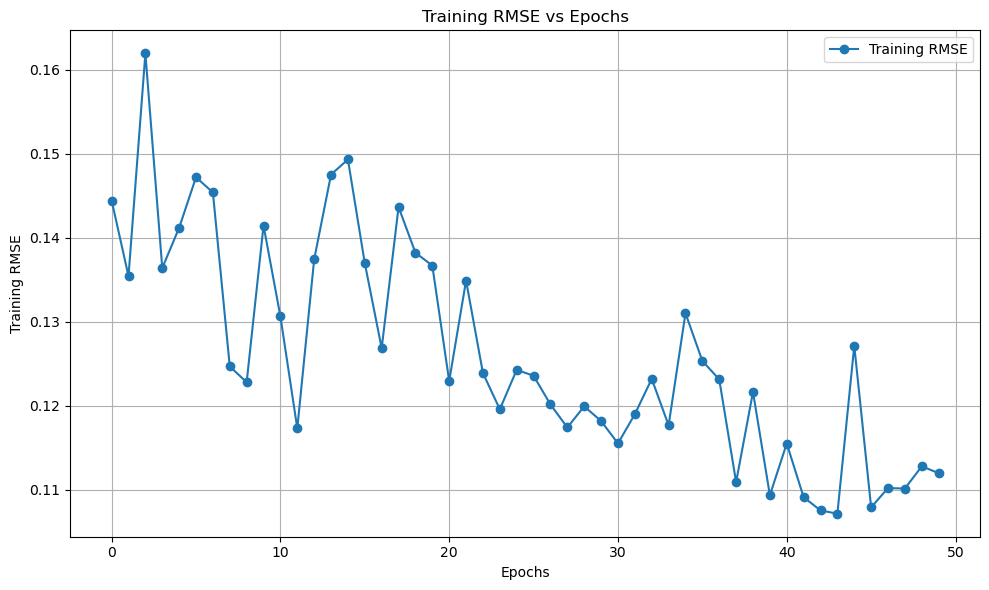

In [31]:
import matplotlib.pyplot as plt

epochs = range (50)
plt.figure(figsize = (10, 6))
plt.plot(epochs, train_errors, label = 'Training RMSE', marker = 'o')
plt.title('Training RMSE vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

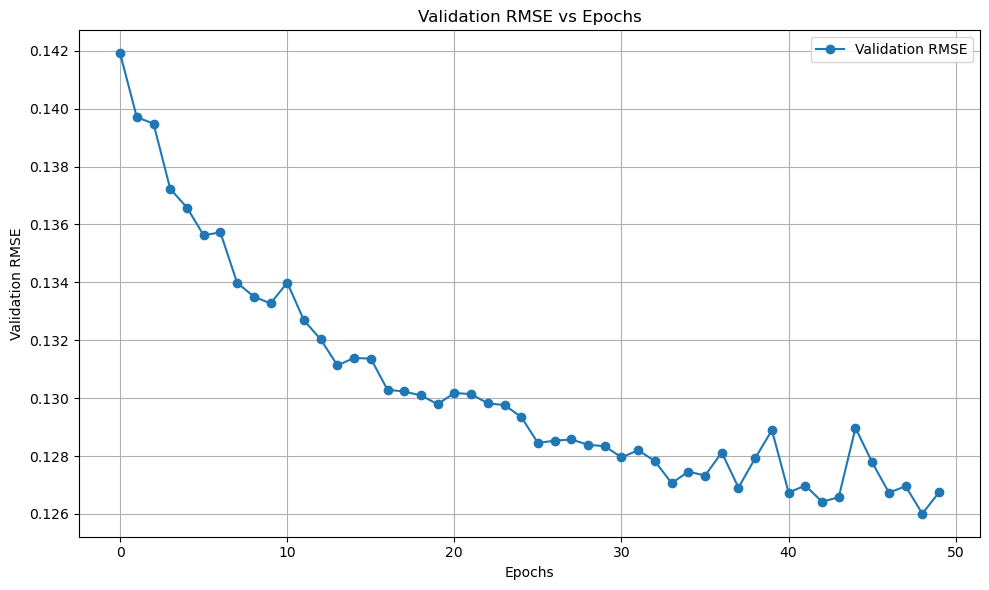

In [32]:
plt.figure(figsize = (10, 6))
plt.plot(epochs, valid_errors, label = 'Validation RMSE', marker = 'o')
plt.title('Validation RMSE vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

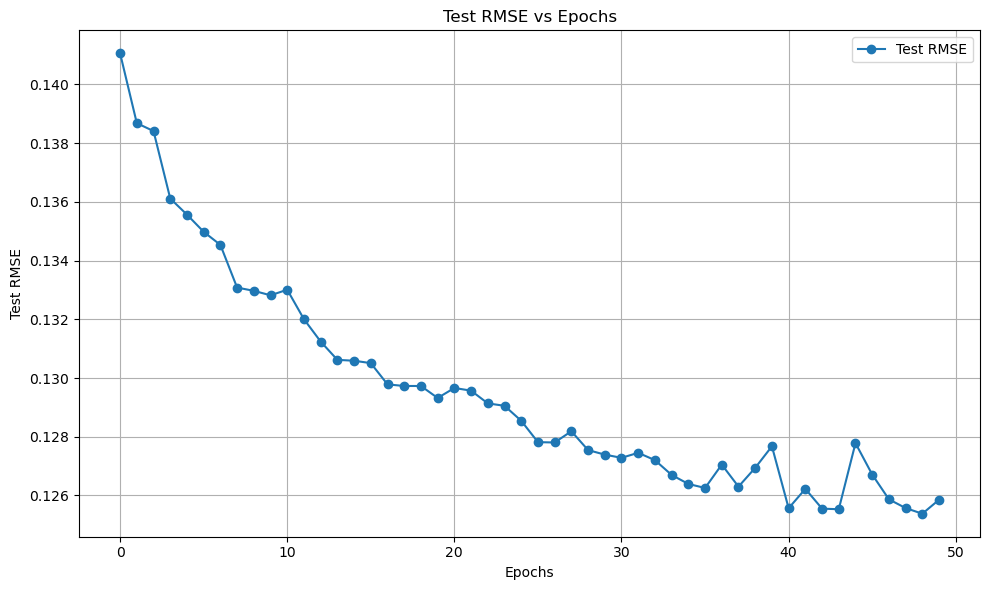

In [33]:
plt.figure(figsize = (10, 6))
plt.plot(epochs, test_errors, label = 'Test RMSE', marker = 'o')
plt.title('Test RMSE vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()